<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/rapids-cuDF-cuml-02-linear-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cuML - Linear Regression

In [1]:
!nvidia-smi

Thu Sep 12 01:08:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!wget -nc https://github.com/rapidsai/notebooks-extended/raw/master/utils/rapids-colab.sh
!bash rapids-colab.sh

import sys, os

sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

--2019-09-12 01:08:18--  https://github.com/rapidsai/notebooks-extended/raw/master/utils/rapids-colab.sh
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rapidsai/notebooks-contrib/raw/master/utils/rapids-colab.sh [following]
--2019-09-12 01:08:23--  https://github.com/rapidsai/notebooks-contrib/raw/master/utils/rapids-colab.sh
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rapidsai/notebooks-contrib/master/utils/rapids-colab.sh [following]
--2019-09-12 01:08:23--  https://raw.githubusercontent.com/rapidsai/notebooks-contrib/master/utils/rapids-colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.co

### Required Imports

In [12]:
import cudf
import cuml
import gzip
import math
import sklearn
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import cos, sin, asin, sqrt, pi, atan2
from numba import cuda
from sklearn.linear_model import LinearRegression
from cuml.linear_model import LinearRegression as LinearRegressionGPU

# select a particular GPU to run the notebook
os.environ["CUDA_VISIBLE_DEVICES"]="2"

%matplotlib inline

print('NumPy Version:', np.__version__)
print('Scikit-learn Version:', sklearn.__version__)
print('cuDF Version:', cudf.__version__)
print('cuML Version:', cuml.__version__)

NumPy Version: 1.16.5
Scikit-learn Version: 0.21.3
cuDF Version: 0.10.0a+1233.gf8e8353
cuML Version: 0.10.0a+456.gb96498b


### Helper Functions

In [4]:
!git clone https://github.com/Quansight/scipy-2019-rapids-tutorial

Cloning into 'scipy-2019-rapids-tutorial'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 245 (delta 144), reused 170 (delta 82), pack-reused 0
Receiving objects: 100% (245/245), 35.10 MiB | 22.41 MiB/s, done.
Resolving deltas: 100% (144/144), done.


In [0]:
dataset = 'scipy-2019-rapids-tutorial/cuml/data/mortgage.npy.gz'

if not os.path.exists(dataset):
  print('Unable to find dataset.')

In [0]:
def load_data(nrows, ncols, cached = dataset):
  # split the dataset in a 80:20 split
  train_rows = int(nrows*0.8)
  with gzip.open(cached) as f:
    X = np.load(f)
    print(X)
  

In [14]:
%%time

nrows = 2 **20
ncols = 399

load_data(nrows, ncols)

[[0.6666667  0.19690022 0.0045045  ... 0.         0.         1.        ]
 [0.6666667  0.19690022 0.00900901 ... 0.         0.         1.        ]
 [0.6666667  0.19690022 0.01351351 ... 0.         0.         1.        ]
 ...
 [0.5555556  0.34976676 0.1981982  ... 0.         0.         1.        ]
 [0.5555556  0.34976676 0.2027027  ... 0.         0.         1.        ]
 [0.5555556  0.34899753 0.2072072  ... 0.         0.         1.        ]]
CPU times: user 4.33 s, sys: 615 ms, total: 4.94 s
Wall time: 4.95 s


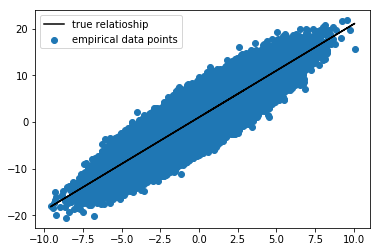

In [0]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relatioship')
plt.legend()

In [0]:
%%time
linear_regression = LinearRegression()
linear_regression.fit(np.expand_dims(x, 1), y)

CPU times: user 29.4 ms, sys: 1.04 ms, total: 30.5 ms
Wall time: 46.2 ms


Create new data and perform inference

In [0]:
inputs = np.linspace(start=-5, stop=5, num=1000000)

In [0]:
outputs = linear_regression.predict(np.expand_dims(inputs, 1))

Let's now visualize our empirical data points

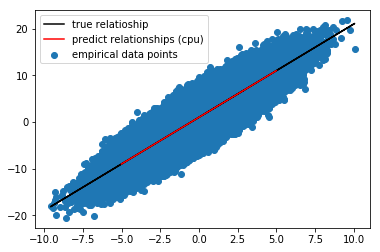

In [0]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relatioship')
plt.plot(inputs, outputs, color='red', label='predict relationships (cpu)')
plt.legend()

In [0]:
df = cudf.DataFrame({'x': x, 'y': y_noisy})
df.head(5)

,x,y
0,2.930472,7.108608
1,0.721014,2.735794
2,5.390496,11.656830
3,1.035208,2.065743
4,3.796838,11.080224


In [0]:
%%time
# instantiate and fit model
linear_regression_gpu = LinearRegressionGPU()
linear_regression_gpu.fit(df[['x']], df['y'])

CPU times: user 738 ms, sys: 301 ms, total: 1.04 s
Wall time: 1.13 s


In [0]:
new_data_df = cudf.DataFrame({'inputs': inputs})

In [0]:
outputs_gpu = linear_regression_gpu.predict(new_data_df[['inputs']])

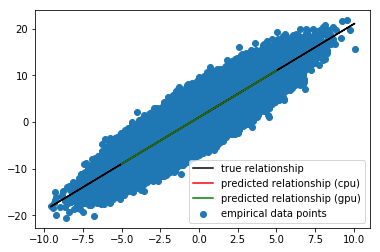

In [0]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.plot(inputs, outputs_gpu.to_array(), color='green', label='predicted relationship (gpu)')
plt.legend()